# Sentiment analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import nltk
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import pipeline
from scipy.special import softmax
from sentence_transformers import SentenceTransformer, util
from scipy.interpolate import interp1d

nltk.download('punkt')

c:\Users\march\anaconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\march\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
DATA_PATH = "../../../data/our_movie_data_extended.csv"
df_extended = pd.read_csv(DATA_PATH)[["Wikipedia_movie_ID", "summary", "category"]]
df_extended.dropna(subset=["summary"], inplace=True)
df_extended.sample(3)

Wikipedia_movie_ID                                            summary  \
34531            13861681  Set in London and the south of England in 1929...   
72809            32037191  A small town guy tries to decide between stayi...   
48459            21241505  When stage actress Judy Carroll testifies on b...   

                                     category  
34531  ['Fantasy/Sci-Fi', 'Horror', 'Others']  
72809                   ['Comedy', 'Romance']  
48459                     ['Drama', 'Others']

### Version of sentiment analysis using emotions and segments

In [4]:
device = 0 if torch.cuda.is_available() else 'cpu'

In [15]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, device=device)
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

big_df = pd.DataFrame()

limit = 2 # You can adjust the limit as needed
threshold = 0.5

#iterate over summaries
for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)
    embeddings = sentence_model.encode(sentences, convert_to_tensor=True)

    # Segment the text based on cosine similarity
    segments = []
    current_segment = [sentences[0]]

    for i in range(len(sentences) - 1):
        similarity = util.pytorch_cos_sim(embeddings[i], embeddings[i + 1]).item()

        if similarity < threshold:
            segments.append(" ".join(current_segment))
            current_segment = []

        current_segment.append(sentences[i + 1])

    #final segment join
    segments.append(" ".join(current_segment))

    # Classify the segments for emotions
    out = classifier(segments)
    emotions_flattened = [{item['label']: item['score'] for item in entry} for entry in out]
    emotions = pd.DataFrame(emotions_flattened)

    emotions['segment_id'] = [i for i in range(len(segments))]
    emotions['segment'] = [segments[i] for i in range(len(segments))]
    emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions)
    
    big_df = pd.concat([big_df, emotions], ignore_index=True)

print(big_df.shape)

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

(19, 10)


### Version of sentiment analysis using sentences and emotions

In [16]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, device=device)
big_df = pd.DataFrame()

limit = 2 # You can adjust the limit as needed

for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)

    out = classifier(sentences)

    emotions_flattened = [{item['label']: item['score'] for item in entry} for entry in out]
    emotions = pd.DataFrame(emotions_flattened)

    emotions['sentence_id'] = [i for i in range(len(sentences))]
    emotions['sentence'] = [sentences[i] for i in range(len(sentences))]
    emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions) 

    big_df = pd.concat([big_df, emotions], ignore_index=True)
print(big_df.shape)

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]

(25, 10)


### Version of sentiment analysis using positive/negative only

In [17]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
dict_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}

big_df = pd.DataFrame()

limit = 10 # You can adjust the limit as needed

for idx, t in tqdm(df_extended['summary'].iloc[:limit].items(), total=len(df_extended['summary'].iloc[:limit])):
    sentences = nltk.sent_tokenize(t)
    for idx_s, s in enumerate(sentences):
        t_encoded = tokenizer(s, return_tensors='pt')
        t_output = model(**t_encoded)
        scores = softmax(t_output.logits.detach().numpy(), axis=1)
        
        emotions = pd.DataFrame(scores, columns=[dict_labels[i] for i in range(3)])
        emotions['sentence_id'] = idx_s
        emotions['Wikipedia_movie_ID'] = [df_extended.iloc[idx]['Wikipedia_movie_ID']] * len(emotions) 

        big_df = pd.concat([big_df, emotions], ignore_index=True)
print(big_df.shape)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]

(297, 5)


In [48]:
big_df.head(20)

negative   neutral  positive  sentence_id  Wikipedia_movie_ID
0   0.005653  0.821786  0.172561            0                 330
1   0.255226  0.724555  0.020220            0                3217
2   0.755420  0.235866  0.008714            1                3217
3   0.110220  0.838336  0.051444            2                3217
4   0.119391  0.574379  0.306231            3                3217
5   0.005951  0.482136  0.511913            4                3217
6   0.013369  0.838581  0.148051            5                3217
7   0.027470  0.903485  0.069045            6                3217
8   0.046110  0.917408  0.036482            7                3217
9   0.138054  0.813180  0.048766            8                3217
10  0.735591  0.255277  0.009132            9                3217
11  0.477244  0.501119  0.021637           10                3217
12  0.069061  0.870357  0.060583           11                3217
13  0.020519  0.709521  0.269959           12                3217
14  0.580510  0.396928  0.022561           13                3217
15  0.162925  0.803216  0.033858           14                3217
16  0.521193  0.455428  0.023379           15                3217
17  0.225668  0.744003  0.030329           16                3217
18  0.207780  0.751402  0.040819           17                3217
19  0.065643  0.794790  0.139567           18                3217

# Analyzing results

In [5]:
# Define the paths to the data files
DATA_PATH = "../../../data/sentence_emotions_5000.csv"  # Path to the CSV file containing sentence emotions data
DATA_PATH_MOVIE_METADATA = "../../../data/our_movie_data_extended.pkl"  # Path to the pickle file containing movie metadata

df_emotions = pd.read_csv(DATA_PATH)

with open(DATA_PATH_MOVIE_METADATA, 'rb') as f:
    df_metadata = pickle.load(f)

df_metadata.sample(3)

Wikipedia_movie_ID                                            summary  \
16773             5708633  The Great New Wonderful is a series of vignett...   
25215             9549760                                                NaN   
17922             6158979                                                NaN   

      Freebase_movie_ID               Movie_name  Movie_release_date  \
16773         /m/0f0d1p  The Great New Wonderful              2006.0   
25215        /m/02pjmp9    Flight of Black Angel              1991.0   
17922         /m/0ft95_         Crocodile Hunter                 NaN   

       Movie_box_office_revenue  Movie_runtime   Movie_languages  \
16773                  172055.0           87.0  English Language   
25215                       NaN          115.0  English Language   
17922                       NaN            NaN         Cantonese   

                Movie_countries                               Movie_genres  \
16773  United States of America  Drama, Ensemble Film, Comedy-drama, Indie   
25215  United States of America                                   Thriller   
17922                 Hong Kong                     Comedy, Chinese Movies   

                      category      continent  
16773  [Comedy, Drama, Others]  North America  
25215               [Thriller]  North America  
17922         [Comedy, Others]           Asia

In [6]:
target_timesteps = 20  # Number of timesteps to which we want to interpolate the data
emotions = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"] 

def interpolate_emotions(movie_data, target_timesteps):
    """
    Interpolates emotion values over a fixed number of timesteps for a given movie data.

    This function takes a DataFrame containing emotion values over time for a specific movie
    and interpolates each emotion to fit a fixed number of timesteps. This is useful for standardizing
    the data across movies with different numbers of timestamps, allowing for easier comparison.

    Args:
        movie_data (pd.DataFrame): A DataFrame containing emotion values for a specific movie.
            Each row represents a timestep, and columns should include:
            - "Wikipedia_movie_ID" (int or str): The unique identifier for the movie.
            - One column per emotion (e.g., "anger", "disgust", "fear", etc.).
        target_timesteps (int): The target number of timesteps for interpolation. The function
            will output a DataFrame with this fixed number of rows.

    Returns:
        pd.DataFrame: A DataFrame with `target_timesteps` rows, containing the interpolated
        emotion values. Columns include:
            - "Wikipedia_movie_ID" (int or str): Repeated ID of the movie for each row.
            - One column per emotion (e.g., "anger", "disgust", "fear", etc.) with interpolated values.
            
    Notes:
        - This function uses linear interpolation. For other types of interpolation,
          change the `kind` parameter in `interp1d`.
        - The function extrapolates values if the target positions extend beyond the range
          of `movie_data`.

    """
    # Define the original positions based on the length of the input data
    original_positions = np.arange(len(movie_data))
    # Define the target positions for interpolation based on the target timesteps
    target_positions = np.linspace(0, len(movie_data) - 1, target_timesteps)
    
    # Initialize a dictionary to store the interpolated data
    interpolated_data = {emotion: [] for emotion in emotions}
    # Add the Wikipedia_movie_ID to the dictionary, repeating it for each target timestep
    interpolated_data["Wikipedia_movie_ID"] = [movie_data["Wikipedia_movie_ID"].iloc[0]] * target_timesteps
    
    # Interpolate each emotion's values over the target positions
    for emotion in emotions:
        # Create a linear interpolation function for the current emotion
        interp_function = interp1d(original_positions, movie_data[emotion], kind="linear", fill_value="extrapolate")
        interpolated_data[emotion] = interp_function(target_positions)

    return pd.DataFrame(interpolated_data)

In [7]:
interpolated_movies = []

for movie_id, movie_data in df_emotions.groupby("Wikipedia_movie_ID"):
    # Apply the interpolate_emotions function to get a fixed number of timesteps for this movie
    interpolated_movie = interpolate_emotions(movie_data, target_timesteps)
    interpolated_movies.append(interpolated_movie)

interpolated_df = pd.concat(interpolated_movies, ignore_index=True)

# Add a timestep column to indicate the timestep index within each movie
interpolated_df['timestep'] = interpolated_df.groupby("Wikipedia_movie_ID").cumcount()

c:\Users\march\anaconda3\envs\ada\Lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [8]:
# The NaN are due to the extrapolation on single sentence summaries (we should get rif of them and scrape)
interpolated_df.isna().sum()

anger                 760
disgust               760
fear                  760
joy                   760
neutral               760
sadness               760
surprise              760
Wikipedia_movie_ID      0
timestep                0
dtype: int64

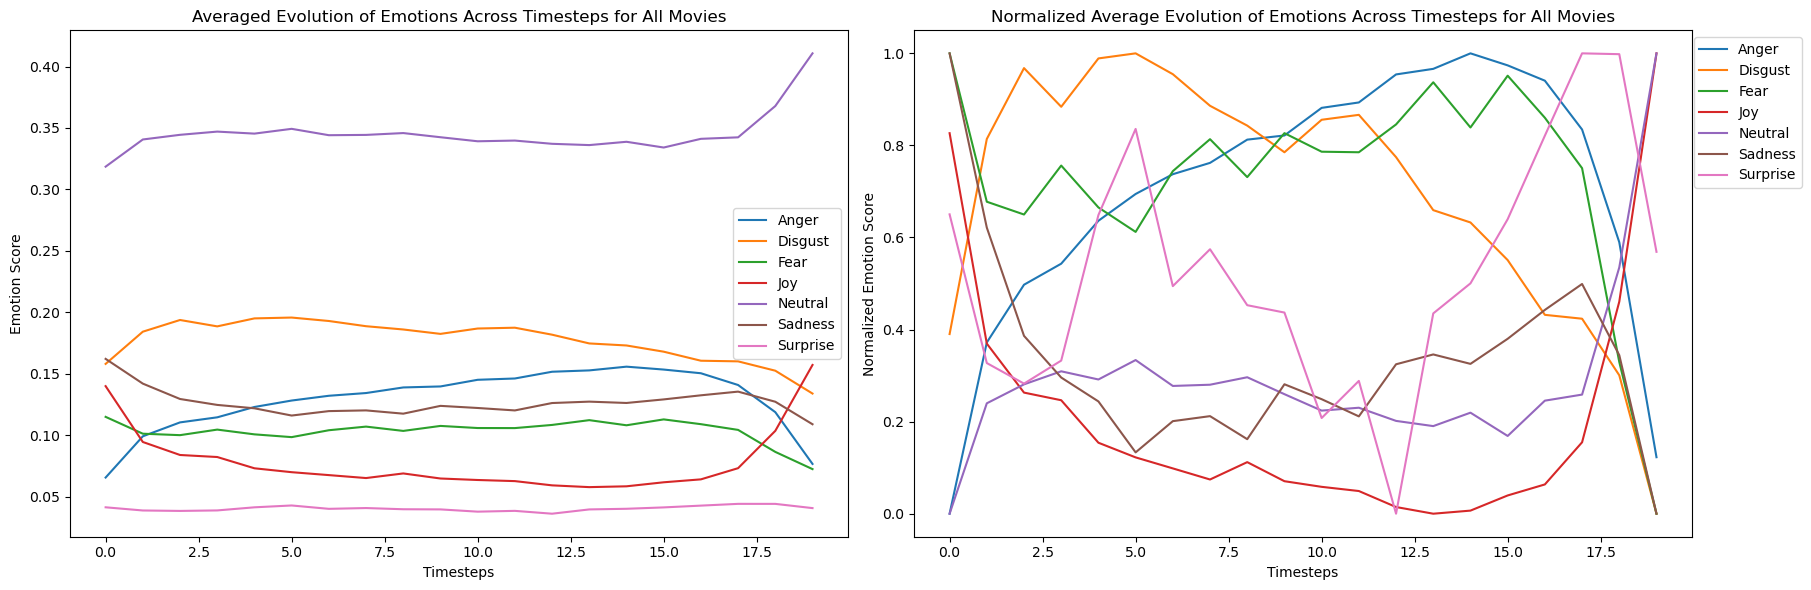

In [9]:
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
avg_emotions = interpolated_df.groupby("timestep")[emotions].mean()

#avg_emotions = avg_emotions[:target_timesteps]

#MinMax Normalization
normalized_emotions = avg_emotions.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

#ZScore Normalization
fig, axes = plt.subplots(1, 2,figsize=(18, 6))
axes = axes.ravel()
for emotion in emotions:
    axes[0].plot(range(target_timesteps), avg_emotions[emotion], label=emotion.capitalize())
    axes[1].plot(range(target_timesteps), normalized_emotions[emotion], label=emotion.capitalize())
axes[0].set_title("Averaged Evolution of Emotions Across Timesteps for All Movies")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Emotion Score")
axes[0].legend(loc="best")
axes[1].set_title("Normalized Average Evolution of Emotions Across Timesteps for All Movies")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Normalized Emotion Score")
axes[1].legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

### Now we can try for movies in already formed genres

In [10]:
df_exploded = interpolated_df.merge(df_metadata[["Wikipedia_movie_ID", "category"]], on="Wikipedia_movie_ID")

# create 1 row per movie per genre (so if a film is associated to 3 genres, it will have 3 rows)
df_exploded = df_exploded.explode("category")

# Compute the mean of emotions per category and per timestep
df_grouped_by_genre = df_exploded.groupby(["category", "timestep"])[emotions].mean()

df_grouped_by_genre

anger   disgust      fear       joy   neutral  \
category         timestep                                                     
Action/Adventure 0         0.066540  0.158170  0.115147  0.136765  0.312444   
                 1         0.106388  0.179040  0.097174  0.090381  0.343654   
                 2         0.112624  0.192289  0.095612  0.080071  0.352053   
                 3         0.116872  0.189911  0.105522  0.078756  0.344649   
                 4         0.128178  0.202720  0.096689  0.068721  0.349219   
...                             ...       ...       ...       ...       ...   
War/Crime        15        0.154698  0.151563  0.112976  0.061043  0.347516   
                 16        0.147422  0.149593  0.107858  0.065546  0.357334   
                 17        0.148052  0.151862  0.118026  0.071572  0.333238   
                 18        0.113019  0.137654  0.089043  0.102427  0.385446   
                 19        0.069492  0.131706  0.080817  0.144945  0.426901   

                            sadness  surprise  
category         timestep                      
Action/Adventure 0         0.169829  0.041105  
                 1         0.142573  0.040790  
                 2         0.129488  0.037864  
                 3         0.122697  0.041592  
                 4         0.115827  0.038646  
...                             ...       ...  
War/Crime        15        0.131647  0.040559  
                 16        0.127632  0.044616  
                 17        0.134150  0.043101  
                 18        0.123950  0.048461  
                 19        0.109439  0.036700  

[280 rows x 7 columns]

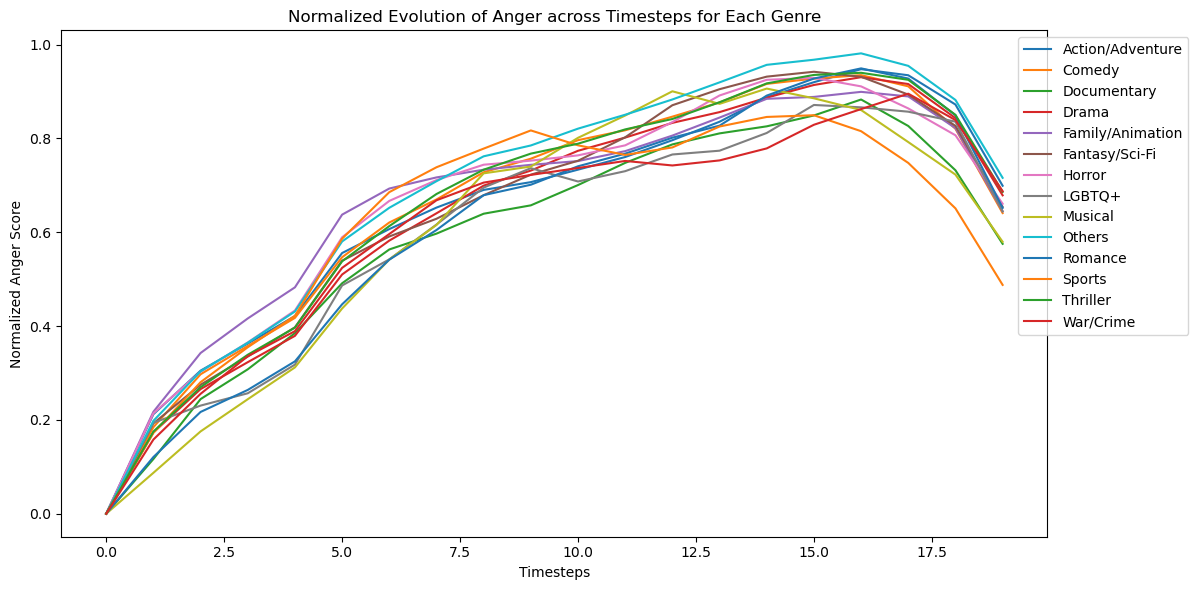

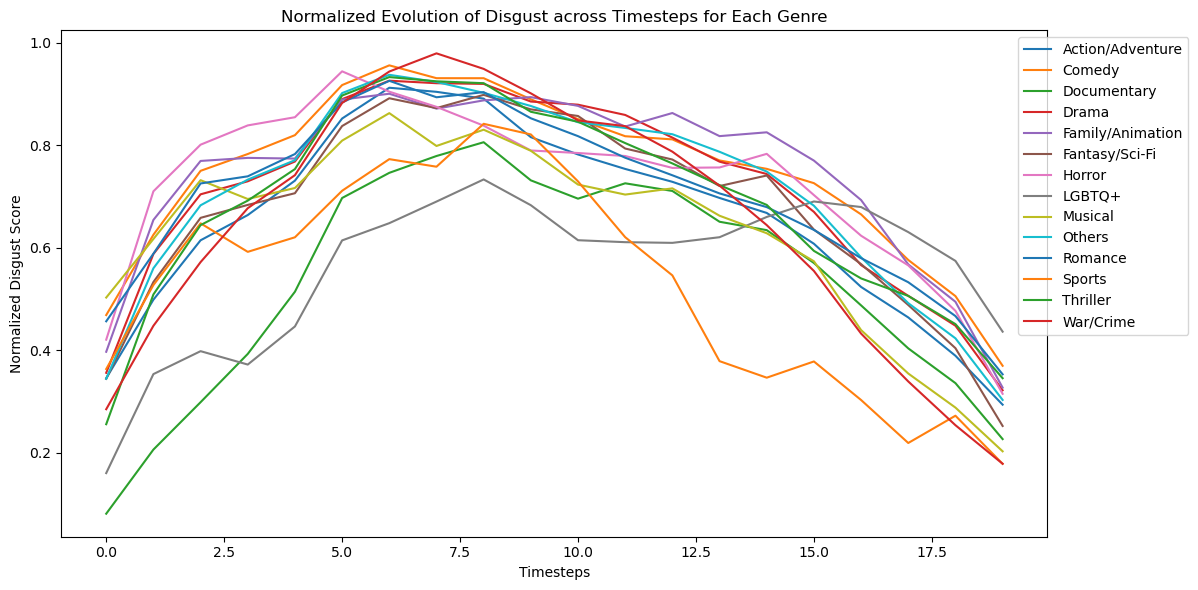

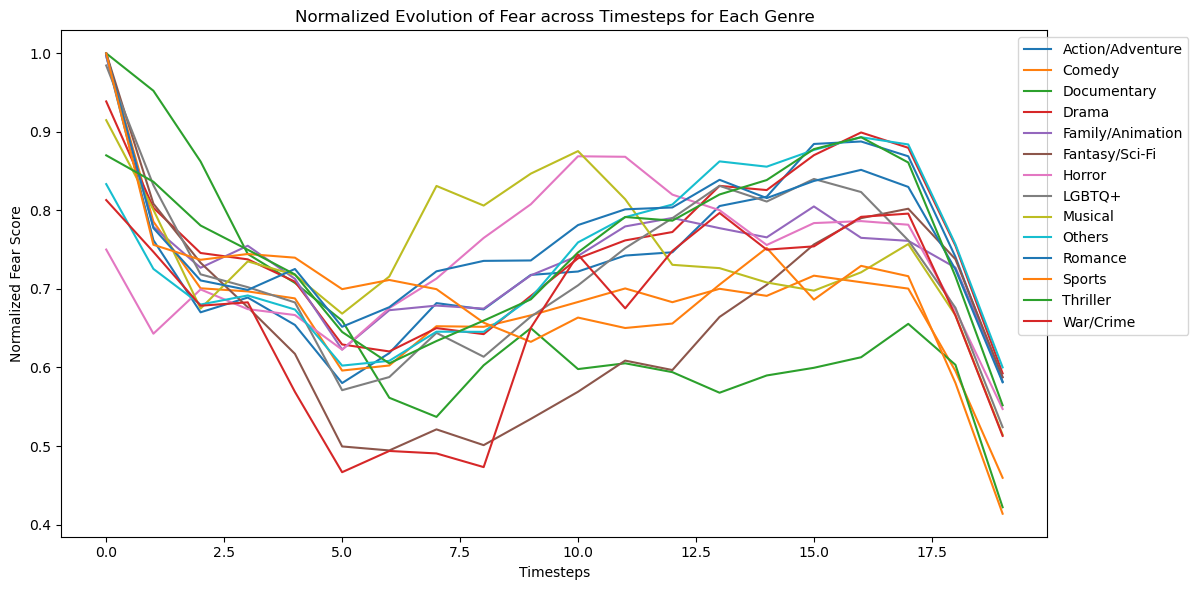

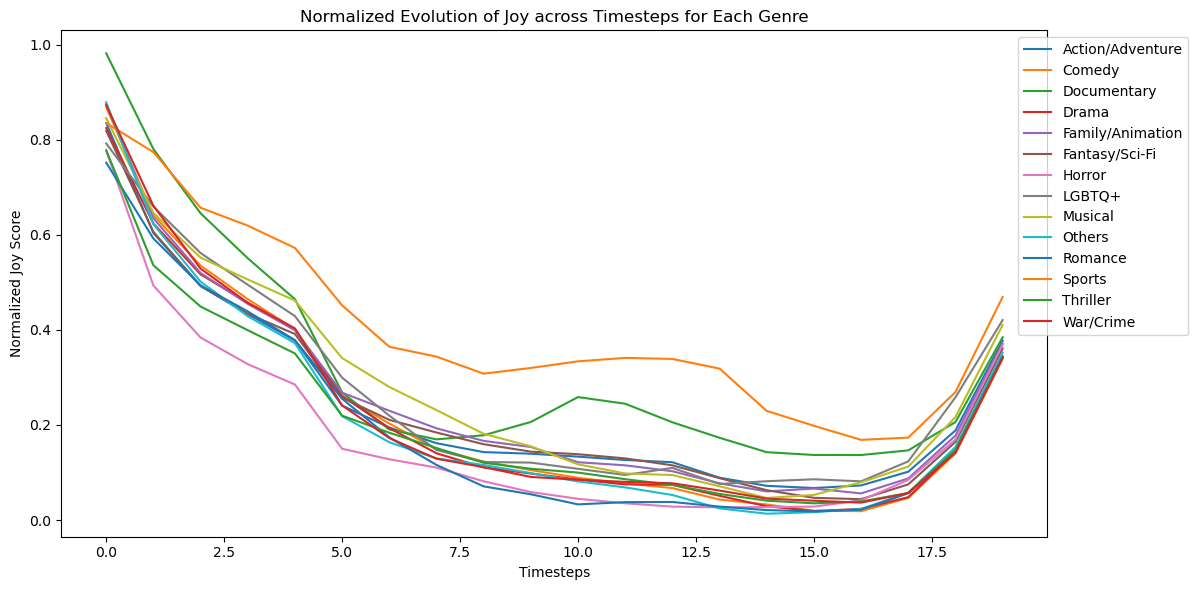

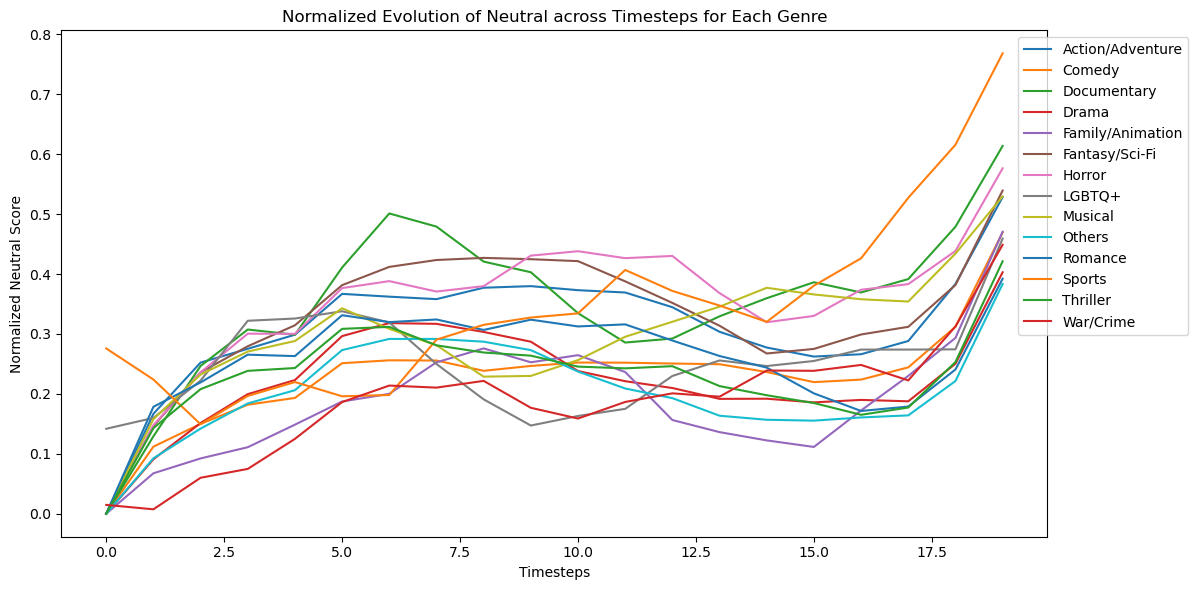

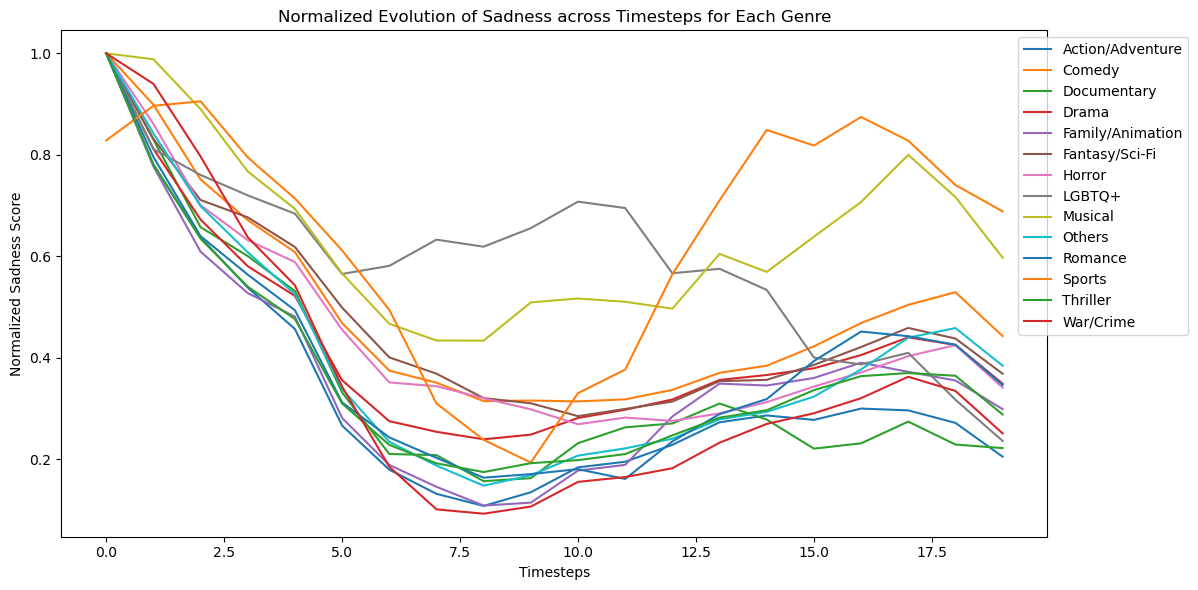

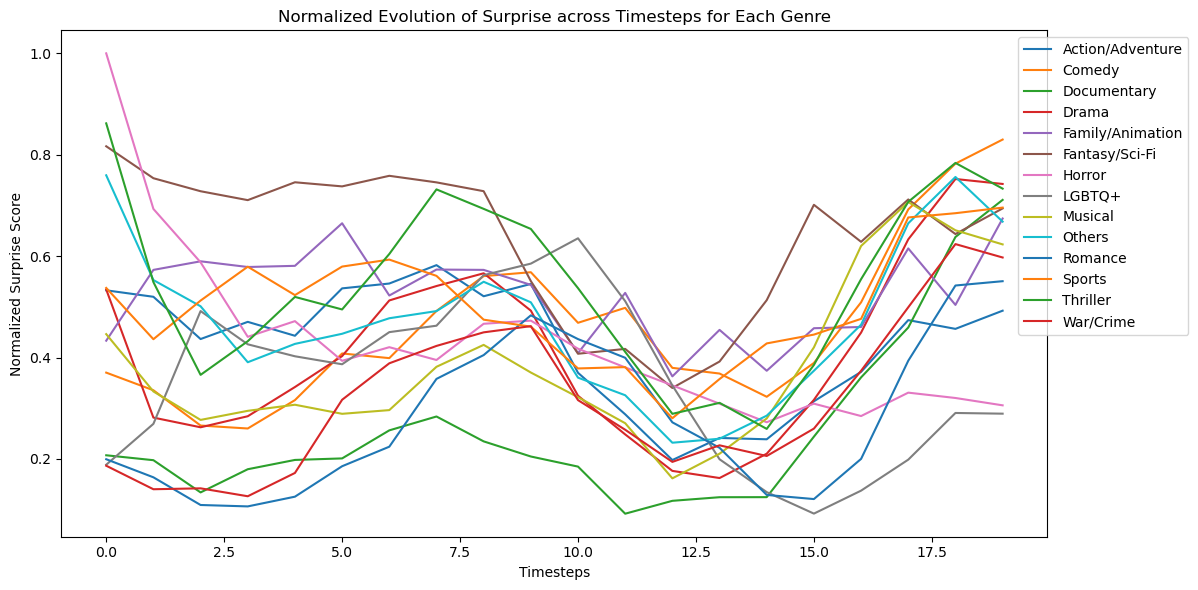

In [11]:
# Define a rolling window size for smoothing
window_size = 5

# Loop through each emotion to plot its evolution across timesteps for each genre
for emotion in emotions:
    plt.figure(figsize=(12, 6))
    
    # Pivot the DataFrame to have genres as columns and timesteps as the index for the current emotion
    avg_emotion_by_genre = df_grouped_by_genre[emotion].unstack(level=0)
    # Normalize each genre's emotion scores across timesteps (min-max normalization)
    avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    
    # Apply rolling mean to smooth the emotion data over the defined window size
    smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

    for genre in smoothed_avg_emotion_by_genre.columns:
        plt.plot(smoothed_avg_emotion_by_genre.index, smoothed_avg_emotion_by_genre[genre], label=genre)
    
    plt.title(f"Normalized Evolution of {emotion.capitalize()} across Timesteps for Each Genre")
    plt.xlabel("Timesteps")
    plt.ylabel(f"Normalized {emotion.capitalize()} Score")
    
    plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    
    plt.show()

In [12]:
continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']

df_exploded = interpolated_df.merge(df_metadata[["Wikipedia_movie_ID", "category", "continent"]], on="Wikipedia_movie_ID")

# Explode the "category" column to separate rows if a movie has multiple categories
df_exploded = df_exploded.explode("category")
# Group by "continent", "category", and "timestep" to analyze emotions by continent and genre over time
df_groupy_by_continent = df_exploded.groupby(["continent", "category", "timestep"])[emotions].mean()

In [13]:
# Assign individual DataFrames to variables for each continent for easy access
africa_df =  df_groupy_by_continent.xs('Africa', level='continent')
asia_df = df_groupy_by_continent.xs('Asia', level='continent')
europe_df = df_groupy_by_continent.xs('Europe', level='continent')
na_df = df_groupy_by_continent.xs('North America', level='continent')
oceania_df = df_groupy_by_continent.xs('Oceania', level='continent')
sa_df = df_groupy_by_continent.xs('South America', level='continent')

# Create a list containing all the continent-specific DataFrames for convenience
dfs = [africa_df, asia_df, europe_df, na_df, oceania_df, sa_df]

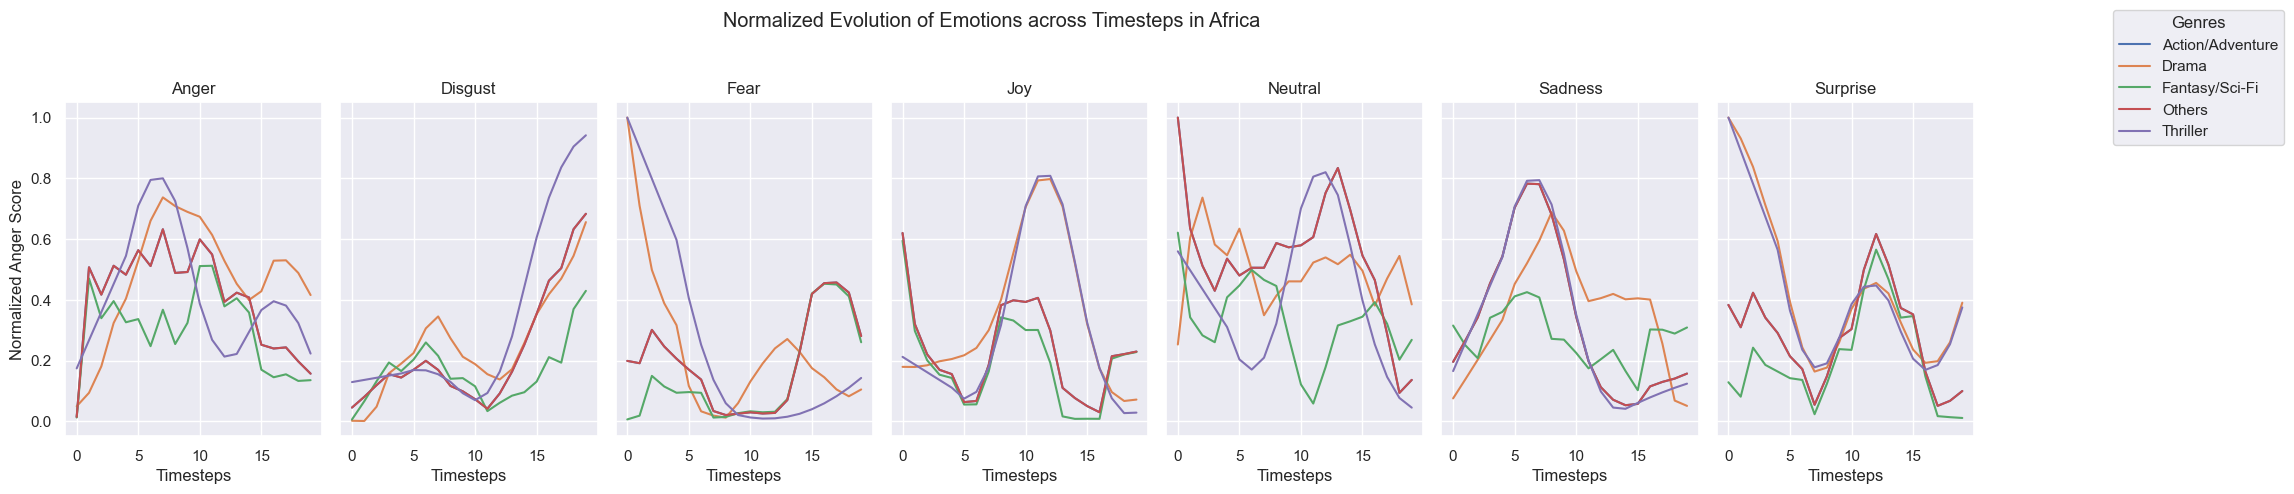

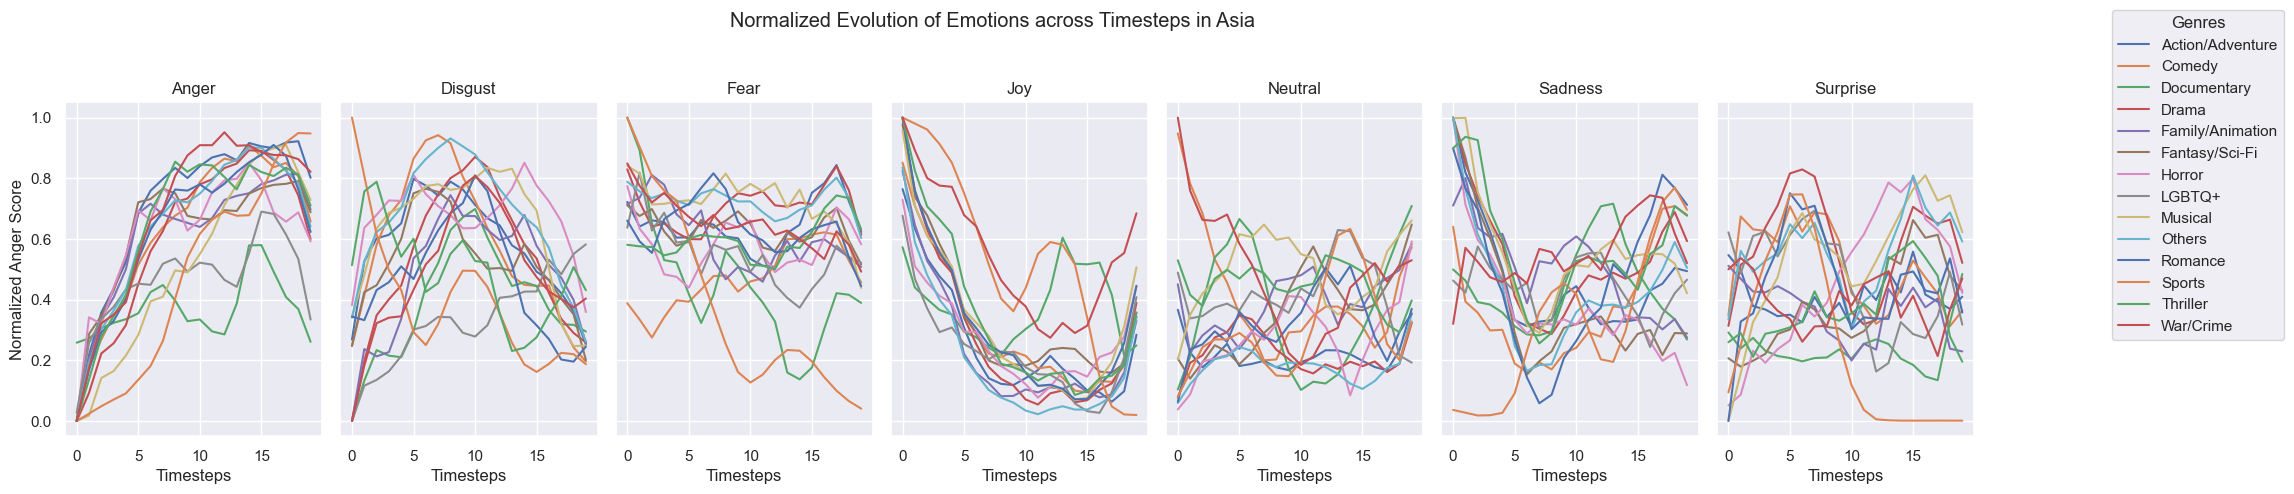

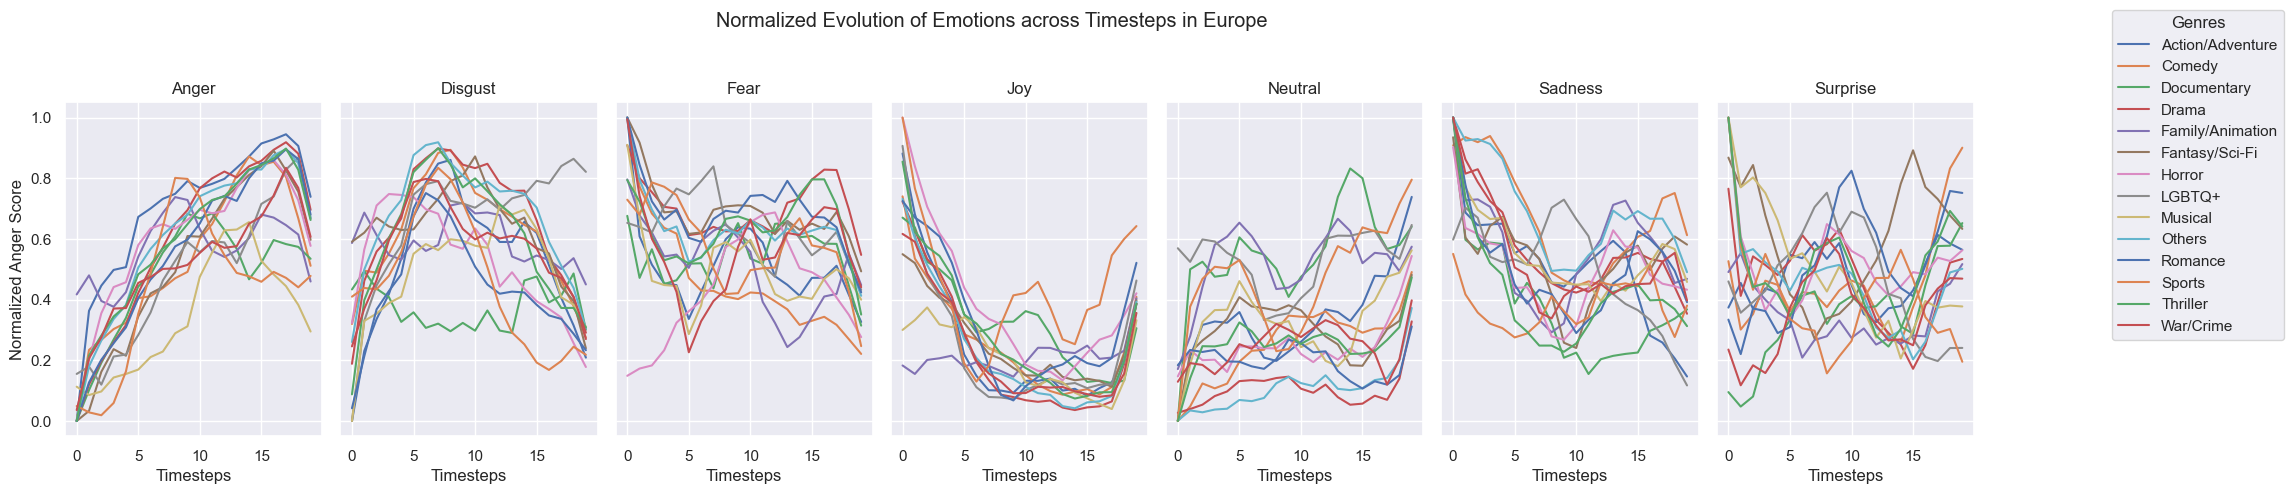

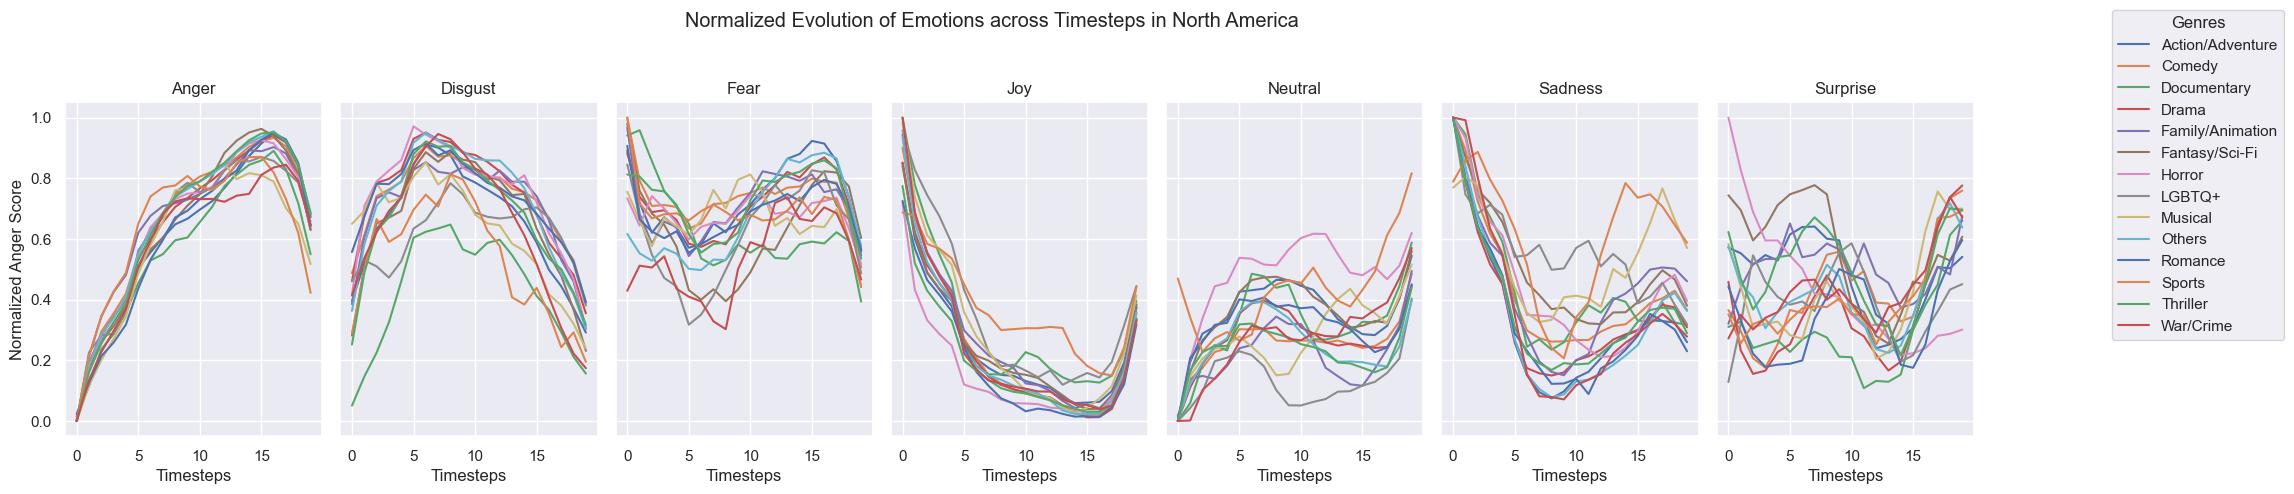

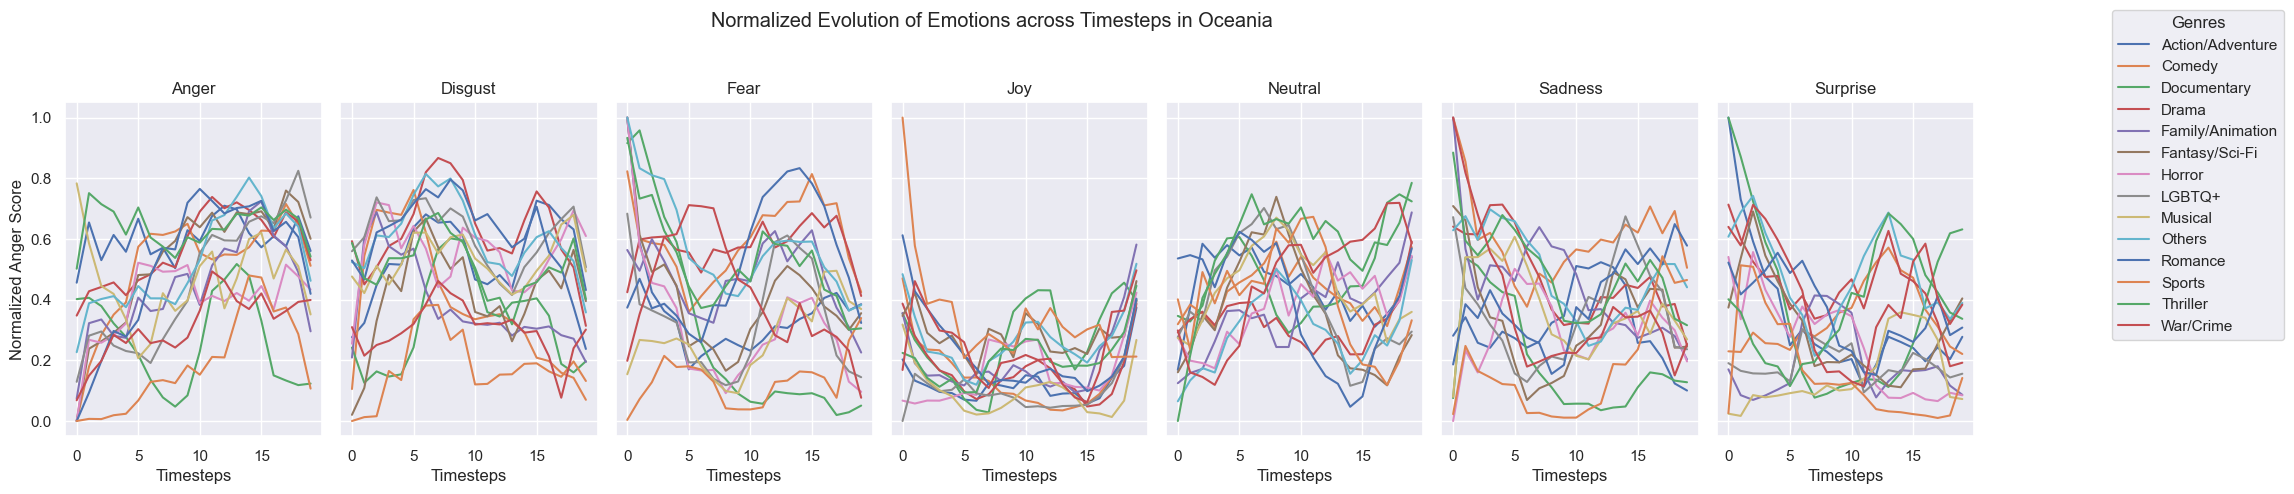

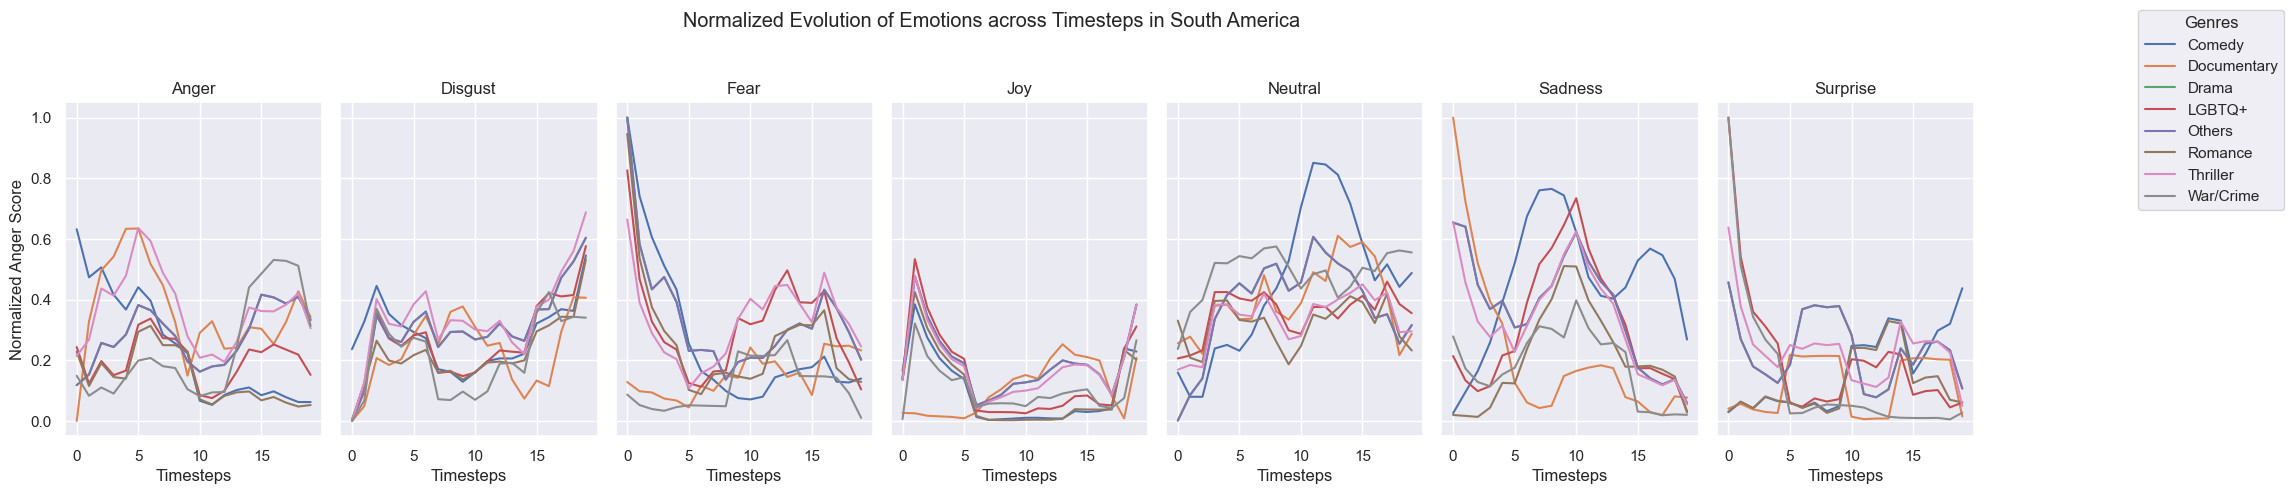

In [14]:
sns.set(style="darkgrid")

for continent_name, df_continent in zip(continents, dfs):
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps in {continent_name}")

    handles = []
    labels = []
    legend_created = False

    for ax, emotion in zip(axes, emotions):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_continent[emotion].unstack(level=0)

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        # Plot each genre's emotion evolution on the corresponding subplot
        for genre in smoothed_avg_emotion_by_genre.columns:
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

## using box office now

use the dataset without much cleaning to see if we can predict something with the data

In [15]:
# Group by 'Wikipedia_movie_ID' and calculate the mean of every emotion per film
df_boxoffice = interpolated_df.groupby('Wikipedia_movie_ID').mean()

# Merge with metadata to add movie-specific attributes such as category, box office revenue, runtime, and release date
df_boxoffice = df_boxoffice.merge(
    df_metadata[["Wikipedia_movie_ID", "category", "Movie_box_office_revenue", "Movie_runtime", "Movie_release_date"]],
    on="Wikipedia_movie_ID"
)

# Drop rows with any missing values to ensure only complete data rows are kept
df_boxoffice = df_boxoffice.dropna(axis=0)
df_boxoffice.sample(3)

Wikipedia_movie_ID     anger   disgust      fear       joy   neutral  \
490               113427  0.046392  0.252668  0.159997  0.054892  0.339326   
2806             1134373  0.069268  0.157086  0.147187  0.023417  0.451322   
3011             1233576  0.133542  0.174725  0.066094  0.066674  0.324823   

       sadness  surprise  timestep  \
490   0.109211  0.037514       9.5   
2806  0.056379  0.095341       9.5   
3011  0.208938  0.025205       9.5   

                                               category  \
490   [Family/Animation, Drama, Others, Romance, Com...   
2806          [Thriller, Others, Drama, Fantasy/Sci-Fi]   
3011                                           [Comedy]   

      Movie_box_office_revenue  Movie_runtime  Movie_release_date  
490                108423489.0          132.0              1983.0  
2806                  424760.0           77.0              2004.0  
3011               216614388.0          107.0              1988.0

In [16]:
#separate X and y for the train test split. 
#We keep category for y, so we can explose y_train and y_test after the split on the category
X = df_boxoffice.drop(columns=["Movie_box_office_revenue"])
y = pd.DataFrame(df_boxoffice[["Movie_box_office_revenue", "category"]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) #test_size = 0.15 yiels better r2 score than .2

# One-hot encode the 'category' column in the training data to handle categorical genres
X_train = pd.get_dummies(X_train.explode('category'), columns=['category'])
# Only keep the boxoffice for y as it is the only thing that interest us here
y_train = pd.get_dummies(y_train.explode('category'), columns=['category'])['Movie_box_office_revenue']
X_test = pd.get_dummies(X_test.explode('category'), columns=['category'])
y_test = pd.get_dummies(y_test.explode('category'), columns=['category'])['Movie_box_office_revenue']

In [18]:
# Define a pipeline with two main steps: scaling and regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Step 1: Standardize features
    ("regressor", RandomForestRegressor(random_state=42))  # Step 2: Random Forest Regressor
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [19]:
#compute some metrics about the model
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

r2 = r2_score(y_test, y_pred)
print("R-squared (R²):", r2)
mean_boxoffice = y_test.mean()
print(f"mean of boxoffice = {round(mean_boxoffice, 2)}")
std_boxoffice = y_test.std()
print(f"std of boxoffice = {round(std_boxoffice, 2)}")

Mean Absolute Error (MAE): 82278642.17794897
Mean Squared Error (MSE): 1.9565630190848812e+16
Root Mean Squared Error (RMSE): 139877196.82224408
R-squared (R²): -0.04788503023482771
mean of boxoffice = 78501833.04
std of boxoffice = 136710951.27


Text(0.5, 0, 'Boxoffice revenue in dollars')

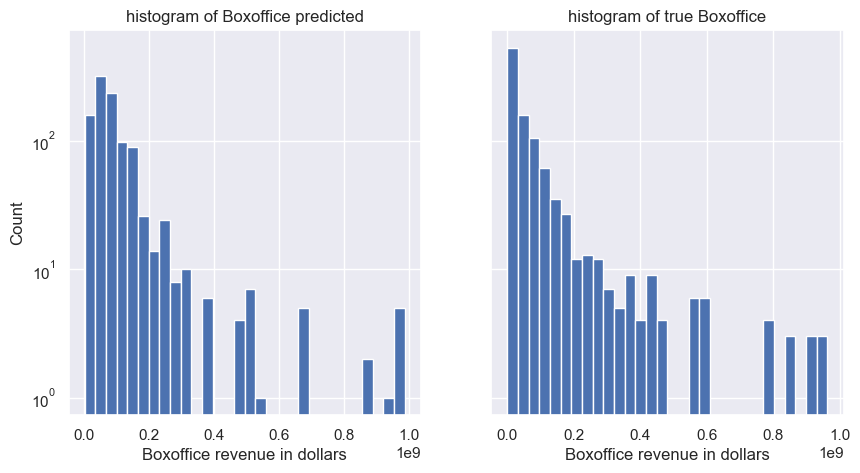

In [20]:
#plot the histogram of the prediction and the true value on a log scale
_, axes = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
axes = axes.ravel()
axes[0].hist(y_pred, bins=30)
axes[0].set_title('histogram of Boxoffice predicted')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Boxoffice revenue in dollars')
axes[0].set_yscale('log')
axes[1].hist(y_test,bins=30)
axes[1].set_title('histogram of true Boxoffice')
axes[1].set_xlabel('Boxoffice revenue in dollars')

### Plot the boxoffice of every genre for every continent


In [21]:
#As we care only about the boxoffice, and we have 20 timesteps/film, we take only 1 film every 20.
df_boxoffice = interpolated_df.iloc[::20].merge(df_metadata[["Wikipedia_movie_ID","category", "continent", "Movie_box_office_revenue"]], on="Wikipedia_movie_ID")
#drop every rows (movies) that does not have the box_office
df_boxoffice = df_boxoffice.dropna(subset=['Movie_box_office_revenue'], axis=0)[['category', 'continent', 'Movie_box_office_revenue']]
df_boxoffice = df_boxoffice.explode('category')
#compute the mean per category per continent
df_boxoffice_mean_by_category_and_genre = df_boxoffice.groupby(['category', 'continent']).mean()

In [22]:
df_boxoffice_mean_by_category_and_genre =df_boxoffice_mean_by_category_and_genre.reset_index()
continents = np.unique(df_boxoffice_mean_by_category_and_genre['continent'])

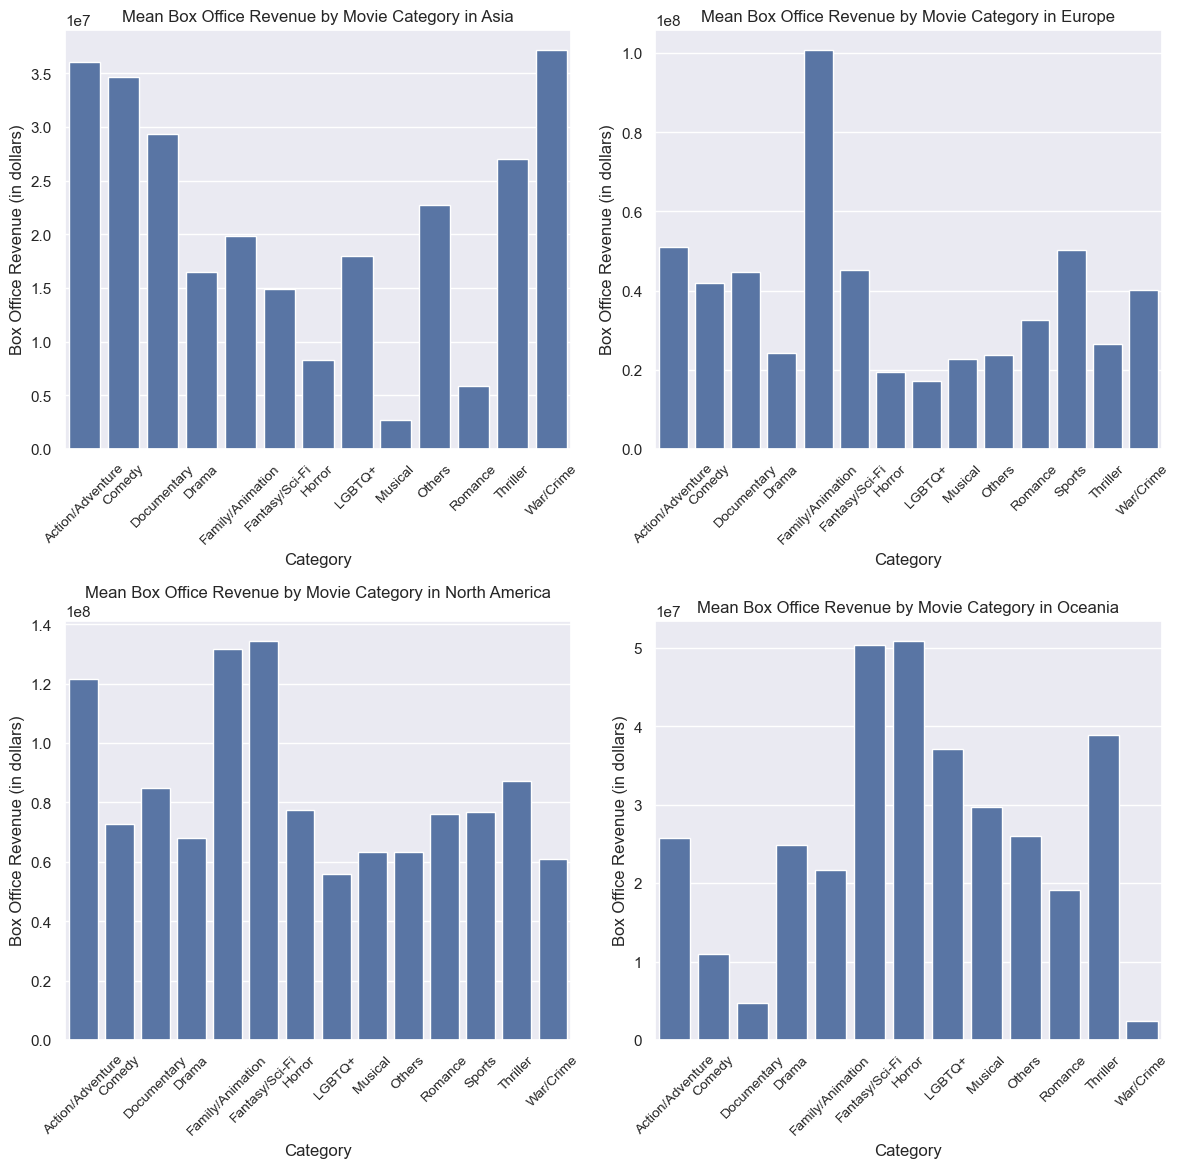

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()
for ax, continent in zip(axes, continents):
    df = df_boxoffice_mean_by_category_and_genre[df_boxoffice_mean_by_category_and_genre['continent'] == continent]
    sns.barplot(data=df, x="category", y="Movie_box_office_revenue", ax=ax)

    ax.set_title(f"Mean Box Office Revenue by Movie Category in {continent}")
    ax.set_xlabel("Category")
    ax.set_ylabel("Box Office Revenue (in dollars)")
    ax.tick_params(axis='x', rotation=45, labelright=False, labelsize=10)
plt.tight_layout()